#### SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time
import h5py
from sklearn.model_selection import train_test_split
from hep_VQAE import QAE_pennylane as pQAE

import warnings
warnings.filterwarnings('ignore')

2022-09-20 17:12:25.772652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 17:12:25.772669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### data 

In [2]:
f = h5py.File("../../data/electron.hdf5","r")
f2 = h5py.File("../../data/photon.hdf5","r")

electrons = f.get('X')[:,:,:,0]
photons = f2.get('X')[:,:,:,0]
electrons_y = f.get('y')[:]
photons_y = f2.get('y')[:]

In [3]:
x_train, x_val, y_train, y_val = train_test_split(np.vstack((electrons,photons)),
                                                    np.transpose(np.hstack((electrons_y, photons_y))),
                                                    test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [4]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_electrons = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [5]:
x_train = x_train.reshape(x_train.shape + (1,))
x_train_electrons = x_train_electrons.reshape(x_train_electrons.shape + (1,))

x_val = x_val.reshape(x_val.shape + (1,))
x_val_electrons = x_val_electrons.reshape(x_val_electrons.shape + (1,))

x_test = x_test.reshape(x_test.shape + (1,))
x_test_electrons = x_test_electrons.reshape(x_test_electrons.shape + (1,))

In [6]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],32,32,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

In [7]:
x_train = crop_and_resize(x_train, 0, 12, crop_fraction=0.8)
x_train_electrons = crop_and_resize(x_train_electrons, 0, 12, crop_fraction=0.8)

x_val = crop_and_resize(x_val, 0, 12, crop_fraction=0.8)
x_val_electrons = crop_and_resize(x_val_electrons, 0, 12, crop_fraction=0.8)

x_test = crop_and_resize(x_test, 0, 12, crop_fraction=0.8)
x_test_electrons = crop_and_resize(x_test_electrons, 0, 12, crop_fraction=0.8)

2022-09-20 17:12:42.314424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 17:12:42.314444: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 17:12:42.314462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-09-20 17:12:42.314830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 17:12:42.317086: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 488882176 e

In [8]:
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_train_electrons,axis=(1,2)).reshape(x_train_electrons.shape[0],1,1,1)
div[div == 0] = 1
x_train_electrons = x_train_electrons / div

div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1,1)
div[div == 0] = 1
x_val = x_val / div
div = np.max(x_val_electrons,axis=(1,2)).reshape(x_val_electrons.shape[0],1,1,1)
div[div == 0] = 1
x_val_electrons = x_val_electrons / div

div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1,1)
div[div == 0] = 1
x_test = x_test / div
div = np.max(x_test_electrons,axis=(1,2)).reshape(x_test_electrons.shape[0],1,1,1)
div[div == 0] = 1
x_test_electrons = x_test_electrons / div

In [9]:
x_train = x_train.reshape((x_train.shape[0],12,12))
x_train_electrons = x_train_electrons.reshape((x_train_electrons.shape[0],12,12))

x_val = x_val.reshape((x_val.shape[0],12,12))
x_val_electrons = x_val_electrons.reshape((x_val_electrons.shape[0],12,12))

x_test = x_test.reshape((x_test.shape[0],12,12))
x_test_electrons = x_test_electrons.reshape((x_test_electrons.shape[0],12,12))

In [10]:
x_train_small = x_train[:6000]
x_train_electrons_small = x_train_electrons[:6000]
x_test_small = x_test[:1100]
x_test_electrons_small = x_test_electrons[:1100]

In [11]:
x_train.shape

(119356, 12, 12)

### Circuit

In [12]:
DATA_QBITS = 9

LATENT_QBITS = 4
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 12

EPOCHS = 10
DRCs = 3

In [13]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [14]:
model = pQAE.ConvSQAE(DATA_QBITS,
                      LATENT_QBITS, 
                      dev1, 
                      INPUT_DATA_SIZE, 
                      kernel_size=4, 
                      stride=4, 
                      DRCs=DRCs, 
                      diff_method="adjoint")

In [15]:
model.train(x_train_small, x_test_small, 
            learning_rate=0.01, 
            epochs=EPOCHS, 
            batch_size=30, 
            print_step_size=50, 
            save_auc=True,
            x_val_signal=x_test_electrons_small)

Step: 50      | Loss: 0.00332    | avg step time 9.71
Step: 100     | Loss: 0.00043    | avg step time 25.9
Step: 150     | Loss: 9.75e-05   | avg step time 30.9
____
Epoch: 0     | Loss: 0.000162   | Val Loss 0.000168
____
Step: 50      | Loss: 0.000119   | avg step time 9.37
Step: 100     | Loss: 0.000178   | avg step time 25.2
Step: 150     | Loss: 4.28e-05   | avg step time 27.9
____
Epoch: 1     | Loss: 7.55e-05   | Val Loss 7.22e-05
____
Step: 50      | Loss: 6.17e-05   | avg step time 8.4
Step: 100     | Loss: 0.000112   | avg step time 23.0
Step: 150     | Loss: 2.67e-05   | avg step time 21.5
____
Epoch: 2     | Loss: 4.69e-05   | Val Loss 4.43e-05
____
Step: 50      | Loss: 3.86e-05   | avg step time 9.82
Step: 100     | Loss: 7.64e-05   | avg step time 23.7
Step: 150     | Loss: 1.81e-05   | avg step time 25.1



KeyboardInterrupt



Median fidelities bg:  0.9986978867212521
Median fidelities signal:  0.9986839316893987
Median background: 0.0013
Median signal: 0.00132
Maximum accuracy: 0.537
AUC: 0.531


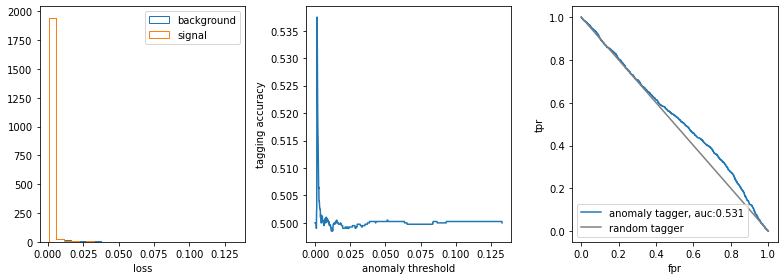

In [16]:
model.evaluate(x_test_small, x_test_electrons_small)

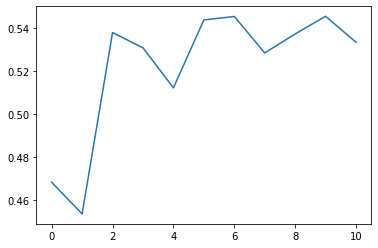

In [17]:
plt.plot(model.auc_hist)

In [13]:
def single_upload(params, data, wire):
    for i, d in enumerate(data.flatten()):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,img.shape[1]-kernel_size+1,stride)))*len(list(range(0,img.shape[0]-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,img.shape[1]-kernel_size+1,stride):
        for x in range(0,img.shape[0]-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(params, data):

    kernel_size = 4
    stride = 4
    
    number_of_kernel_uploads = len(list(range(0,data.shape[1]-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(params[i*num_upload_params:(i+1)*num_upload_params], data, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [14]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE)

kernel_size = 4
stride = 4
number_of_kernel_uploads = len(list(range(0,data.shape[0]-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

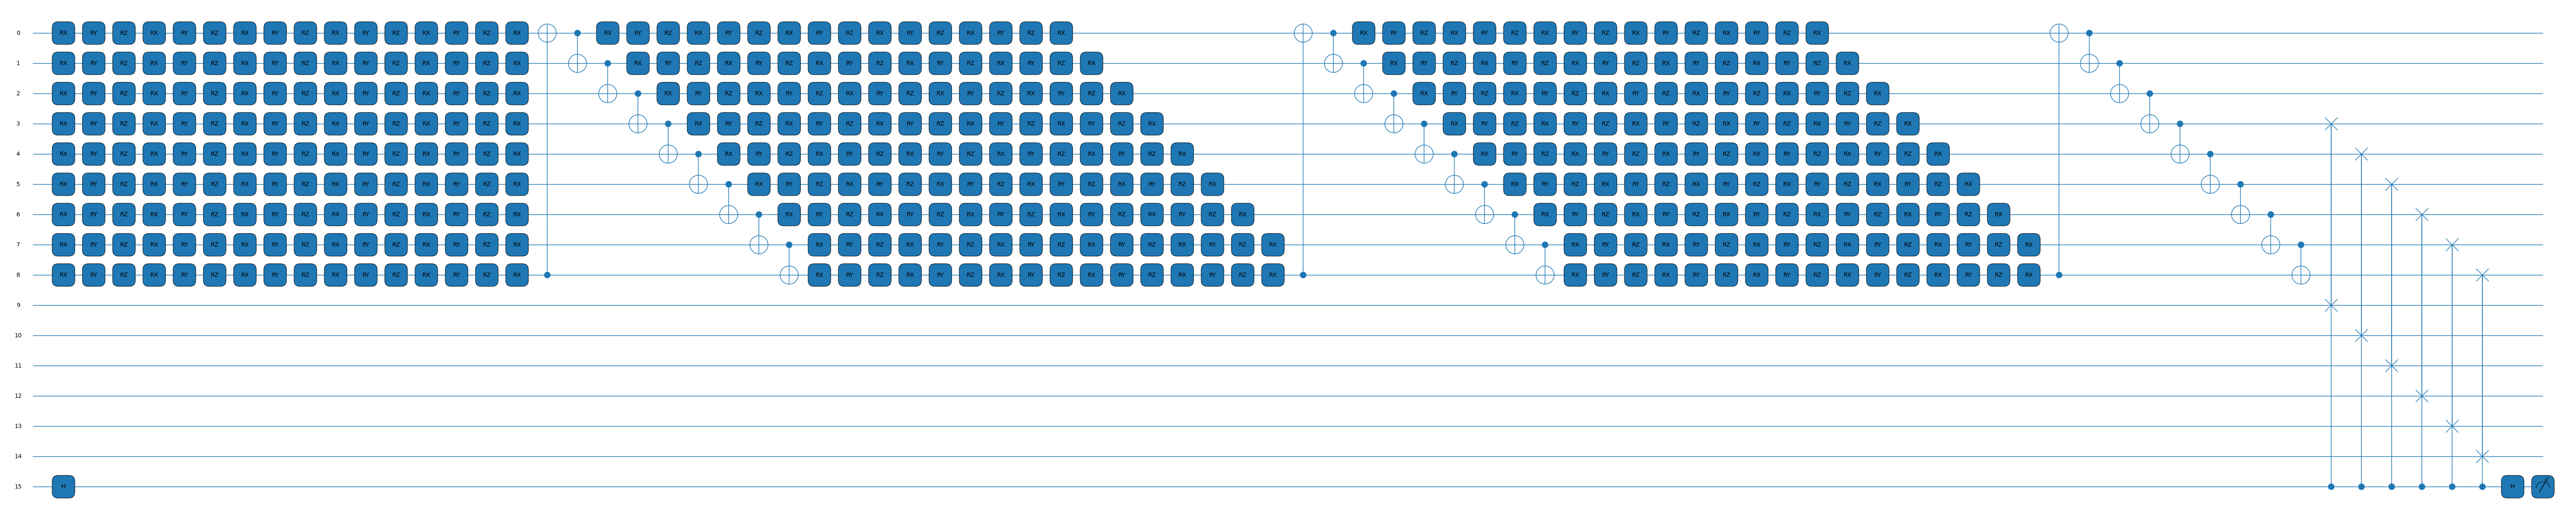

In [15]:
fig, ax = qml.draw_mpl(circuit)(np.ones(DRCs*num_upload_params),data)
fig.show()

In [16]:
def cost_batch(params, batch):
    loss = 0.0
    for i in batch:
        f = circuit(params, i)
        loss = loss + (1 - f) ** 2
    return loss / len(batch)

def cost(params):
    loss = 0.0
    for i in range(len(x_train)):
        f = circuit(params, x_train[i])
        loss = loss + (1 - f) ** 2
    return loss / len(x_train)

def cost_sample(params, single_sample):
    return (1 - circuit(params, single_sample)) ** 2

In [17]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

### training

In [18]:
learning_rate = 0.01
epochs = 5 
batch_size = 30

In [19]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [20]:
weight_shapes = {"weights": (DRCs*num_upload_params)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [21]:
x_train_small = x_train[:5000]
x_train_electrons_small = x_train_electrons[:5000]
x_test_small = x_test[:2000]
x_test_electrons_small = x_test_electrons[:2000]

In [22]:
start = time.time()

for it in range(epochs):
    #start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(x_train_small, batch_size=batch_size)):  
    #for j, sample in enumerate(x_train_small):        
        #sample = np.array(sample, requires_grad=False)
        #cost_fn = lambda p: cost_sample(p, sample)
        cost_fn = lambda p: cost_batch(p, Xbatch)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn) 
        print(j, end="\r")
        #if j % 20 == 0:
        #    end_b = time.time()
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 10 :.3}")
        #    start_b = time.time()

    loss = cost_batch(params,x_train_small[:1000])
    val_loss = cost_batch(params, x_test_small[:1000])
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

____
Epoch: 0 | Loss: 0.00123 | Val Loss 0.00102
____
Time for 1 epochs: 2889.9071950912476


### evaluation

In [25]:
pred_zero = np.array([circuit(params,i) for i in x_test_small])
print("Median zero reconstruciton fidelities: ",np.median(pred_zero))

pred_one = np.array([circuit(params,i) for i in x_test_electrons_small])
print("Median one reconstruciton fidelities: ",np.median(pred_one))

Median zero reconstruciton fidelities:  0.9909130677892852
Median one reconstruciton fidelities:  0.9908857947864961


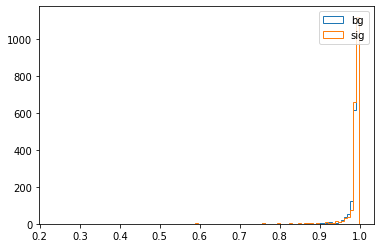

In [26]:
bins = np.histogram(np.hstack((pred_zero.reshape((pred_zero.shape[0],)), pred_one.reshape((pred_one.shape[0],)))), bins=100)[1]
plt.hist(pred_one, histtype='step', label="bg",bins=bins)
plt.hist(pred_zero, histtype='step', label="sig",bins=bins)
plt.legend()

AUC:  0.50614875


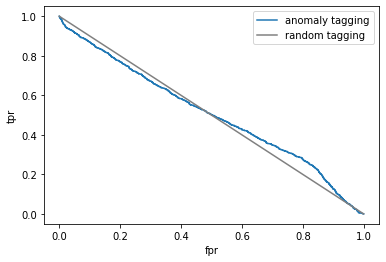

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

#bce_background = 1-pred_six
#bce_signal = 1-pred_three
bce_background = 1-pred_zero
bce_signal = 1-pred_one

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()